# 0. はじめに
この notebook は、 IOAI 2025 対策サーバー第一回コンペ復習会の baseline notebook です。自作のベースラインを使わない人はこのベースラインを使ってください。
## 0.1. このコンペについて
- 画像ファイルが与えられて、その画像が犬か猫かを予測する、二値分類のコンペです。  
- 評価指標は [logloss]() です。
- **今回のコンペは test データに対する予測結果を csv ファイルで提出するだけでいいです。手元で実行して csv ファイルを作ってもよし、 kaggle 上で作って提出してもよし、です**

## 0.2. 今回の目標
- 初心者 : 画像認識の初歩的な実装について学ぶ。
- 中級者 : 様々な画像認識モデルや data augumentation 手法について学ぶ。
- 上級者 : アンサンブルや細かいテクを用いてできるだけ高いスコアを出す

## 0.3. データについて
- train.zip, test.zip, sample_submission.csv という 3 つのファイルが与えられます
- zip の操作 + dataloader の作り方は少し複雑なので、実装を変えないことを推奨します。

## 0.4. コンペ復習会について
- 解く時は基本的に自由にやってもらって大丈夫です。ただし、 IOAI に近い形式にするなら検索 OK 、このコンペの notebook と discussion は参考にしない、とかがいいと思います。
- 解く期間の終了日は 1/22 です。その後、上位陣の解法を見たり、それぞれの解法を見たりします。一つの google slide をみんなで編集する予定です。  

## 0.5. その他
- 何でもわからないところがあったらどんどん質問してください！
- 一部説明は画像認識モデルの基本的な知識があることを前提に書かれています。わからない所があれば適宜調べるか質問してください。
- 初心者じゃない人へ : 一部記述がおかしかったりしたら指摘してくださるとありがたいです！

# 1. ライブラリ読み込みと設定

In [1]:
# いつもの
import os
import gc
import re
import sys
import time
import copy
import random 
import glob 

# zip ファイル用
import zipfile
import shutil

# いつもの
import numpy as np
import pandas as pd

# pytorch 関連
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# 画像関連
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2   
from PIL import Image

# スケジューラのためだけにいれる
import transformers

# 進捗バー
from tqdm import tqdm

# loss と KFold
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold

# 図示
import matplotlib.pyplot as plt

# 警告の無視
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/noboru/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
class CFG :
    debug_one_epoch = True
    debug_one_fold = False
    only_infer = False
    num_workers = 16
    batch_size = 64
    num_epochs = 10
    lr = 1e-3
    early_stopping_round = 5
    random_seed = 42
    n_splits = 5
    model_name = "resnet18" # timm で使うモデル名
    pretrained_path = None
    train_dir = None # 学習データセットのパス
    test_dir = None # テストデータセットのパス
    optimizer = torch.optim.AdamW
    criterion = nn.BCEWithLogitsLoss()
    scheduler = transformers.get_linear_schedule_with_warmup
    input_imgsize = 224
    data_dir = "../input/dogs-vs-cats-redux-kernels-edition/"
    kaggle_working_dir = "/kaggle/working/"
    
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(CFG.random_seed)

if  CFG.debug_one_epoch :
    CFG.num_epochs = 1

print('KAGGLE_URL_BASE' in set(os.environ.keys()))


False


前回から名前を変えた CFG は input_imsize 以外ないはずです。  
input_imsize は、入力する画像をモデル側が指定した正方形のサイズにする必要があるので、その設定をしています。

# 2. submission の形式を確認しよう

In [3]:
submission = pd.read_csv(os.path.join(CFG.data_dir, "sample_submission.csv"))
submission.head(3)

,id,label
0,1,0.5
1,2,0.5
2,3,0.5


# 3. zip ファイルの解凍 & 下準備をしよう
僕の手元だと解凍されているのですが、 kaggle だといちいち解凍する必要があります。

In [4]:
if 'KAGGLE_URL_BASE' in set(os.environ.keys()) :
    kaggle_train_dir = os.path.join(CFG.kaggle_working_dir, "train")
    # すでに解凍されている場合は解凍しない
    if not os.path.exists(kaggle_train_dir) :
        shutil.unpack_archive(os.path.join(CFG.data_dir, "train.zip"), CFG.kaggle_working_dir)
    
    kaggle_test_dir = os.path.join(CFG.kaggle_working_dir, "test")
    if not os.path.exists(kaggle_test_dir) :
        shutil.unpack_archive(os.path.join(CFG.data_dir, "test.zip"), CFG.kaggle_working_dir)
        
    CFG.data_dir = CFG.kaggle_working_dir
    
CFG.train_dir = os.path.join(CFG.data_dir, "train")
CFG.test_dir = os.path.join(CFG.data_dir, "test")

train と test のそれぞれの画像のパスのリストを作ります。また、データ数を見ます。

In [5]:
train_list = glob.glob(os.path.join(CFG.data_dir, "train", "*.jpg"))
test_list = glob.glob(os.path.join(CFG.data_dir, "test", "*.jpg"))

print(f"train data : {len(train_list)}")
print(f"test data : {len(test_list)}")

train data : 25000
test data : 12500


犬と猫それぞれの画像が何枚あるかを見ましょう。

In [6]:
print("the number of dog : ", len([i for i in train_list if "dog" in i]))
print("the number of cat : ", len([i for i in train_list if "cat" in i]))

the number of dog :  25000
the number of cat :  25000


# 4. 画像の扱い方について学ぼう

## 4.1. 画像の表示方法について学ぼう
今回は適当な画像を選んで表示させます。以下のようなコードで表示できます。ついでに画像のサイズも見ます。

../input/dogs-vs-cats-redux-kernels-edition/train/dog.6146.jpg
(499, 375)


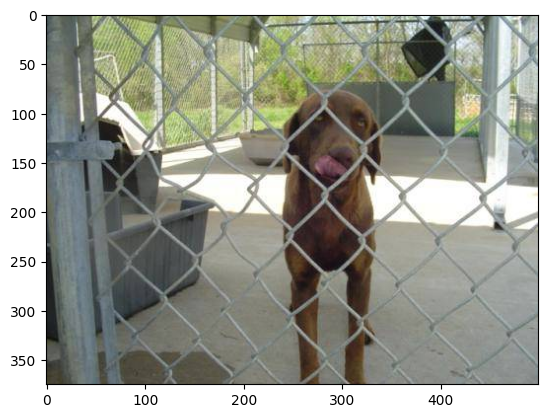

In [7]:
random_img = random.choice(train_list)
img = Image.open(random_img)
print(random_img)
print(img.size)
plt.imshow(img)

## 4.2. 画像のコンピュータ上での扱いについて
そもそも画像データというのはどのように保存されているのでしょうか。 numpy 配列に変換しつつ、実際に確認してみましょう。

In [8]:
img_array = np.array(img)
print(img_array.shape)

(375, 499, 3)


こんな感じで扱っています。 3 次元配列だと思っていただいて構いません。  
H を縦幅、 W を横幅、 C をチャンネル数（ここでは RGB ）として、  [H,W,C] の順に並んでいることを覚えておいてください。

In [9]:
print(img_array[:,:,0])

[[ 68  75  83 ... 161 165 167]
 [ 73  78  84 ... 166 171 175]
 [ 76  80  83 ... 173 178 183]
 ...
 [ 78  75  71 ... 136 136 135]
 [ 80  76  72 ... 137 136 135]
 [ 79  75  70 ... 136 135 134]]


## 4.3. Albumentations を用いた data augumentation について
### 4.3.1. そもそも data augumentation とは
そもそも、 data augumentation とはデータに対して何らかの操作を加えることで、データ数を水増しすることです。モデルの汎化性能を上げたり、過学習を抑える効果があることから、コンペでよく使われます。  
ここでは、画像のデータ拡張用ライブラリである [Albumentations](https://github.com/albumentations-team/albumentations) を使って、様々な手法を確認していきたいと思います。  

### 4.3.2. resize
まずは、一番基本の resize からです。与えられた画像のサイズはバラバラですが、 CNN に入力する際には所定のサイズ（ 214x214 など）にする必要があります。そのサイズ変換をライブラリ側で自動でやってくれます。

dict_keys(['image'])
(224, 224)


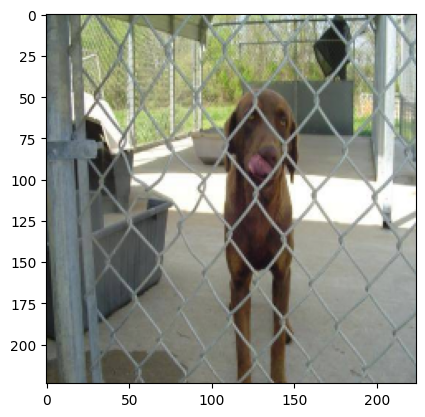

In [10]:
transform_tmp = A.Compose([
    A.Resize(CFG.input_imgsize, CFG.input_imgsize),
])
img_transformed_tmp = transform_tmp(image = np.array(img)) # numpy 配列以外受け取ってくれない
print(img_transformed_tmp.keys())
img_transformed_tmp = Image.fromarray(img_transformed_tmp["image"])
print(img_transformed_tmp.size)
plt.imshow(img_transformed_tmp)

無事 224x224 になりましたね。  
### 4.3.3. hoprizontal flip
次に、 HorizontalFlip を試していきます。画像の左右を反転させます。これも立派な data augumentation の一つです。

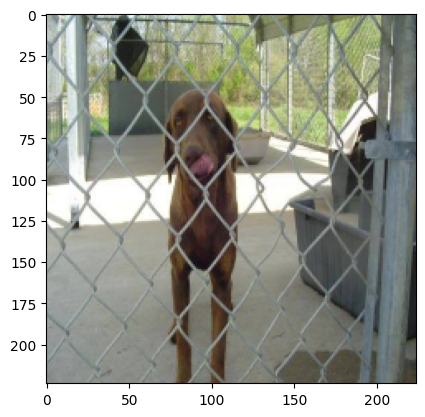

In [11]:
transform_tmp = A.Compose([
    A.Resize(CFG.input_imgsize, CFG.input_imgsize),
    A.HorizontalFlip(p=1.0),
])
img_transformed_tmp = transform_tmp(image = np.array(img))
img_transformed_tmp = Image.fromarray(img_transformed_tmp["image"])
plt.imshow(img_transformed_tmp)


### 4.3.4. normalize
Normalize も試してみましょう。これは、画像の正規化を行う関数です。各画像の値を、指定した平均と標準偏差に基づいて変換することで、学習を安定化させたり、データのスケールを一定の範囲内に収めることができます。  
Albumentations の normalize では、 ImageNet というデータセットの平均の値をデフォルトで使用してくれます。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.6399999].


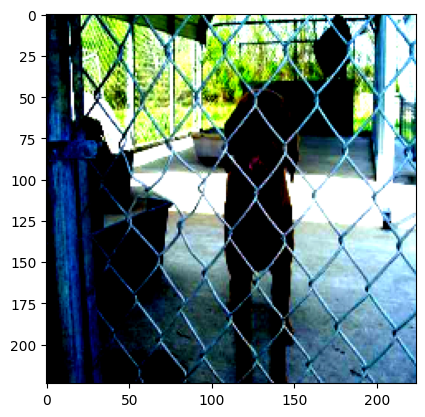

In [12]:
transform_tmp = A.Compose([
    A.Resize(CFG.input_imgsize, CFG.input_imgsize),
    A.Normalize(),
])
img_transformed_tmp = transform_tmp(image = np.array(img))["image"]
plt.imshow(img_transformed_tmp)

人間にはわかりにくくなったかも知れませんが、 NN にとってはこっちのほうがわかりやすい（多分）です。全部値で管理しているので。  
  
### 4.3.5. ToTensorv2
ToTensorv2 という関数の挙動にいついて解説しようと思います。元々、 "HWC" フォーマットで画像を扱っていましたが、 PyTorch を始めとしたライブラリでは "CHW" の順番で扱う必要があります。これをするついでに、 PyTorch の torch.Tensor に変換してくれるのが、この ToTensorv2 です。 
~~ネーミングした人にちょっと文句言いたい......~~  
※以下詳しい人向け  
torchvision の transform に使い慣れている人は、そっちの ToTensor という関数を知っていると思います。そっちとは **挙動がかなり違うらしい** ので気をつけましょう。調べたところ、あっちは勝手に Normalize してくれたり、 0-255 ではなく 0-1 にスケーリングしてくれるらしい？

In [13]:
transform_tmp = A.Compose([
    A.Resize(CFG.input_imgsize, CFG.input_imgsize),
    ToTensorV2()
])
img_transformed_tmp = transform_tmp(image = np.array(img))
print(img_transformed_tmp.keys())
print(type(img_transformed_tmp["image"]))
print(img_transformed_tmp["image"].shape)

dict_keys(['image'])
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


[3,244,244] になっていることから分かる通り、 [C,H,W] の順に並び替えられています。これで一般的な CNN に入力できる形式になりました。  
### 4.3.6. 終わりに
data augumentation には他にもぼかしたり、一部を切り取ったり、画像を拡大したりと本当に様々な操作があります！ [こちらの記事](https://qiita.com/kurilab/items/b69e1be8d0224ae139ad) に色々まとまっているので、たくさん手を動かして試してみてください！

# 5. dataset を作ろう
頑張ってデータセットを作ります。今回は中間の表現として pd.dataframe に path と class をまとめて、それを元に dataset に渡していきます。 class はコンペの通り、犬を 1 、猫を 0 とします。 test データには -1 を割り振ります。

In [14]:
# パスと class をまとめた DataFrame を作成
train_df = pd.DataFrame(train_list, columns=["path"])
train_df["class"] = train_df["path"].apply(lambda x : x.split("/")[-1].split(".")[0])
train_df["class"] = train_df["class"].map({"dog" : 1, "cat" : 0})
test_df = pd.DataFrame(test_list, columns=["path"])
test_df["class"] = -1
# test_df に対しては path の数字が昇順であることを保証するために id を追加
test_df["id"] = test_df["path"].apply(lambda x : int(x.split("/")[-1].split(".")[0]))
test_df = test_df.sort_values("id").reset_index(drop=True)

train_df.head(3)

,path,class
0,../input/dogs-vs-cats-redux-kernels-edition/tr...,0
1,../input/dogs-vs-cats-redux-kernels-edition/tr...,0
2,../input/dogs-vs-cats-redux-kernels-edition/tr...,0


In [15]:
test_df.head(3)

,path,class,id
0,../input/dogs-vs-cats-redux-kernels-edition/te...,-1,1
1,../input/dogs-vs-cats-redux-kernels-edition/te...,-1,2
2,../input/dogs-vs-cats-redux-kernels-edition/te...,-1,3


先ほど行った data augumentation をまとめて定義していきます。

In [16]:
train_transform = A.Compose([
    A.Resize(CFG.input_imgsize, CFG.input_imgsize),
    A.HorizontalFlip(p=0.5), # 50% の確率で水平反転
    A.Normalize(),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Resize(CFG.input_imgsize, CFG.input_imgsize),
    A.Normalize(),
    ToTensorV2()
])

dataset を定義していきます。ここからは前回の notebook も参照してください。説明を少なめにします。

In [17]:
class DogsCatsDataset(Dataset) :
    def __init__(self, df, transform=None) :
        self.df = df # さっきの pandas dataframe を受け取る
        self.transform = transform # 画像の変換処理を受け取る

    def __len__(self) :
        return len(self.df)
    
    def __getitem__(self, idx) :
        img = Image.open(self.df.iloc[idx, 0])
        img = self.transform(image = np.array(img))["image"]
        label = self.df.iloc[idx, 1].astype(np.float32)
        return img, label

# 6. 学習のループを定義しよう
## 6.1. train_one_epoch を定義しよう
前も言った通り、個人的にはこの書き方が一番見やすいと思っています。 dataloader から取り出すものが画像とラベルのセットに（前回から）変わっていることに注意しましょう！

In [18]:
def train_one_epoch(model, dataloader, optimizer, scheduler, criterion) :
    model.train()
    losses = []
    for img, label in tqdm(dataloader) :
        img = img.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output.squeeze(-1),label)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        
    return np.mean(losses)

## 6.2. eval_one_epoch を定義しよう
今回は BCEWithLogitsLoss という損失関数を使って学習を進めているのですが、 logloss も出力できるようにします。  
この時、 BCEWithLogitsLoss の内部で sigmoid 関数が適用されていて、 logits という値を自動で確率に変換していることに注意しましょう。通常のモデルの出力 (output) は logits の値なので、sigmoid 関数を使用して確率に変換する必要があります。  
と言っても初見の人にはわからないと思うので、 [CrossEntropy と BCEWithLogitsLoss の解説](https://qiita.com/ground0state/items/8933f9ef54d6cd005a69) 、[sigmoid の解説](https://cvml-expertguide.net/terms/dl/layers/activation-function/sigmoid/) 、 [sigmoid + BCE の解説](https://cvml-expertguide.net/terms/dl/loss-function/loss-function-part1/) とかを読んでじっくり理解してください！最悪飛ばしても大丈夫です！  
※詳しい人なら「 logloss と BCEWithLogitsLoss は同値では？」という指摘をするかも知れません。厳密には sigmoid を挟んでいるので違うのですが、その点を考慮して考えると同値になる、ということで大丈夫なはずです。

In [19]:
def eval_one_epoch(model, dataloader, criterion) :
    model.eval()
    losses = []
    all_labels = []
    all_outputs = []
    with torch.no_grad() :
        for img, label in tqdm(dataloader) :
            img = img.to(device)
            label = label.to(device)
            output = model(img) # 予測
            loss = criterion(output.squeeze(-1), label) # いらない次元を潰して, loss を計算
            losses.append(loss.item()) # loss をリストに追加
            all_labels.extend(label.cpu().numpy()) # ラベルをリストに追加
            pred = torch.sigmoid(output).cpu().numpy()
            all_outputs.extend(pred) # 予測をリストに追加、 sigmoid で確率に変換
    
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    
    return {
        "bce_loss" : np.mean(losses),
        "log_loss" : log_loss(all_labels, all_outputs),
        "labels" : all_labels,
        "outputs" : all_outputs
    }

## 6.3. infer を定義しよう
例のごとく定義していきます。今回は test の場合 label が -1 なので、一応 assert をかけます。

In [20]:
def infer(model, dataloader, test=False) :
    model.eval()
    all_outputs = []
    with torch.no_grad() :
        for img, label in tqdm(dataloader) :
            if test :
                assert(label[0] == -1)
            img = img.to(device)
            output = model(img)
            all_outputs.extend(torch.sigmoid(output).cpu().numpy()) # 予測をリストに追加、 sigmoid で確率に変換
            
            
    all_outputs = np.array(all_outputs)
    return all_outputs

# 7. CV 1fold 分のループを組もう
先程の関数をフル活用して組んでいきます。  
今回特筆すべき点として、 **[timm](https://huggingface.co/timm)** というライブラリを使っている点があります。このライブラリは、様々な画像向け学習済みモデルが簡単に使える最強ライブラリです。使い方記事は [こちらの記事](https://logmi.jp/main/technology/325674?read_more=1) がとってもわかりやすいです。  
使えるモデル一覧は [ここ（ダウンロード数順）](https://huggingface.co/models?library=timm&sort=downloads) にあります。といってもどれが良いのかわからないと思うので、まずは [この殿堂入りモデルたち](https://huggingface.co/collections/timm/timm-takes-on-the-classics-655ce63dcaa21067cd7d3f4c) とか、さっきのランキングの上位のモデルから試すのをおすすめします。大抵モデル名でググるとそのモデルの特徴が出てくるのでそれも参考にしてみてください！ CFG の model_name を変えるだけですぐに試せます！  
また、今回は out of fold を試してみます。詳しくは [この記事](https://qiita.com/Hatomugi/items/620c1bc757266b00e87f) を参考にしてください。知らなくても大丈夫です。

In [21]:
def run_train_cv(train, test):
    kf = KFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.random_seed)
    oof = np.zeros((len(train), 1)) # out of fold の予測
    predictions =[]
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train)) :
        print(f"====================fold : {fold}====================")
        # df を分割
        train_df = train.iloc[train_idx].reset_index(drop=True)
        valid_df = train.iloc[valid_idx].reset_index(drop=True)
        
        # dataset と dataloader を作成
        train_dataset = DogsCatsDataset(train_df, transform=train_transform)
        valid_dataset = DogsCatsDataset(valid_df, transform=test_transform)
        test_dataset = DogsCatsDataset(test_df, transform=test_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True, pin_memory=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
        
        # timm でモデルを作成、学習済みの重みを読み込む
        model = timm.create_model(CFG.model_name, pretrained=True, num_classes=1)
        model.to(device)
        
        # optimizer と scheduler を作成
        optimizer = CFG.optimizer(model.parameters(), lr=CFG.lr)
        training_steps = len(train_loader) * CFG.num_epochs
        warmup_steps = int(training_steps * 0.1)
        scheduler = CFG.scheduler(optimizer, num_warmup_steps=warmup_steps, num_training_steps=training_steps)
        
        # early stopping のための変数
        best_loss = np.inf
        early_stopping_round = 0
        
        # 学習
        for epoch in range(CFG.num_epochs):
            start_time = time.time() # 時間計測
            train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, CFG.criterion)
            valid_result = eval_one_epoch(model, valid_loader, CFG.criterion)
            print(f"epoch : {epoch} - train loss : {train_loss} - valid loss : {valid_result['bce_loss']} - valid log loss : {valid_result['log_loss']}")
            
            # valid の loss が改善した場合にモデルを保存
            if valid_result["bce_loss"] < best_loss :
                best_loss = valid_result["bce_loss"]
                early_stopping_round = 0
                torch.save(model.state_dict(), f"{CFG.model_name}_fold{fold}.pth")
                
            # 改善しない場合 early stopping の判定をいれる
            else :
                early_stopping_round += 1
                if early_stopping_round > CFG.early_stopping_round :
                    break
            
            print(f"spend time for epoch {epoch} : {time.time() - start_time}")
            
        oof[valid_idx] = infer(model, valid_loader) # valid に対する予測、これを 5 つの fold で集めて合体することで、リークなしで train に対して予測が出来る
        
        del model, optimizer, scheduler
        gc.collect()
        torch.cuda.empty_cache()
        
        if CFG.debug_one_fold :
            break
        
    for fold in range(CFG.n_splits) :
        model = timm.create_model(CFG.model_name, pretrained=True, num_classes=1)
        model.load_state_dict(torch.load(f"{CFG.model_name}_fold{fold}.pth"))
        model.to(device)
        predictions.append(infer(model, test_loader, test=True))
        if CFG.debug_one_fold :
            break
        
    predictions = np.mean(predictions, axis=0)
    
        
    return {
        "oof" : oof,
        "predictions" : predictions
    }


#  8. 実行しよう

In [22]:
def main() :
    if CFG.only_infer :
        test_dataset = DogsCatsDataset(test_df, transform=test_transform)
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
        model = timm.create_model(CFG.model_name, pretrained=True, num_classes=1)
        model.to(device)
        predictions = infer(model, test_loader)
        submission["label"] = predictions
        submission.to_csv("submission.csv", index=False)
       
        
    else :
        result = run_train_cv(train_df, test_df)
        oof_preds = result["oof"]
        predictions = result["predictions"]
        submission["label"] = predictions
        submission.to_csv("submission.csv", index=False)
        train_df["oof_preds"] = oof_preds   
        train_df.to_csv("oof_preds.csv", index=False)
        if CFG.debug_one_fold == False :
            print(f"oof log loss : {log_loss(train_df['class'], oof_preds)}")
        
if __name__ == "__main__" :
    main()

====================fold : 0====================


100%|██████████| 79/79 [00:07<00:00, 10.76it/s]


epoch : 0 - train loss : 0.10235018462975486 - valid loss : 0.032362224402265695 - valid log loss : 0.03271847090751016
spend time for epoch 0 : 58.041794300079346


100%|██████████| 79/79 [00:05<00:00, 14.56it/s]


====================fold : 1====================


100%|██████████| 79/79 [00:07<00:00, 10.49it/s]


epoch : 0 - train loss : 0.10388208962588881 - valid loss : 0.027524195528954645 - valid log loss : 0.027565875793590124
spend time for epoch 0 : 53.717698097229004


100%|██████████| 79/79 [00:06<00:00, 11.34it/s]


====================fold : 2====================


100%|██████████| 79/79 [00:07<00:00, 10.99it/s]


epoch : 0 - train loss : 0.10216698275419334 - valid loss : 0.03133475137697651 - valid log loss : 0.03165228282191299
spend time for epoch 0 : 52.70666146278381


100%|██████████| 79/79 [00:07<00:00, 11.19it/s]


====================fold : 3====================


100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


epoch : 0 - train loss : 0.10157829830840899 - valid loss : 0.038163274541332184 - valid log loss : 0.03856876533906868
spend time for epoch 0 : 51.403164863586426


100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


====================fold : 4====================


100%|██████████| 79/79 [00:08<00:00,  9.81it/s]


epoch : 0 - train loss : 0.10194244654177545 - valid loss : 0.034795498440065714 - valid log loss : 0.035059967168724025
spend time for epoch 0 : 51.720186948776245


100%|██████████| 196/196 [00:15<00:00, 12.78it/s]


oof log loss : 0.03311307253639537


# 9. 改善ポイント
- data augumentation を色々ためそう（全員） : [先程も紹介した記事](https://qiita.com/kurilab/items/b69e1be8d0224ae139ad) に色々あるので、 train の transform に色々追加して試してみてください！
- モデルを色々ためそう（全員） : timm には本当に様々なモデルがあります。 CFG.model_name を変えるだけで試せるのでやってみてください！ベースラインで使った Resnet を改善した様々なモデルがあります！
- アンサンブルをしよう（初中級者～） : CNN で色々試せたり、モデルで色々試せたり、がしやすいのでやりやすいと思います！
- モデルの特性を考えよう（中級者～） : タスクによって得意なモデル / そこまでなモデル、は変わってきます！CNN じゃないタイプのモデルは？その得意なタスクは？思い出しましょう
- ハイパラ調整をしよう（中級者～） : lr とかは恐らくモデルによって変えたほうが良いです。
- 実験管理をしよう（中級者～） : たくさんモデルを作るということは、たくさん管理しなきゃいけないということです。
- 細かいテクをためそう（上級者～） : 今回は前回よりも細かい実験を積み重ねる必要があると思います。色々試してスコアをできるだけ下げましょう！特に評価指標に思いを馳せるとうまくいくと思います。